## Data Loading

Importing the required libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

let's designate the path as a variable so as not to write a long path

In [2]:
path = '../input/chest-xray-pneumonia/chest_xray/chest_xray'

## Visualizing training dataset

Let's look at the data distribution. As we can see, there is a strong imbalance in the data (there are many times more X-rays with pneumonia than normal ones), there are many solutions to the imbalance problem. I offer my solution below.

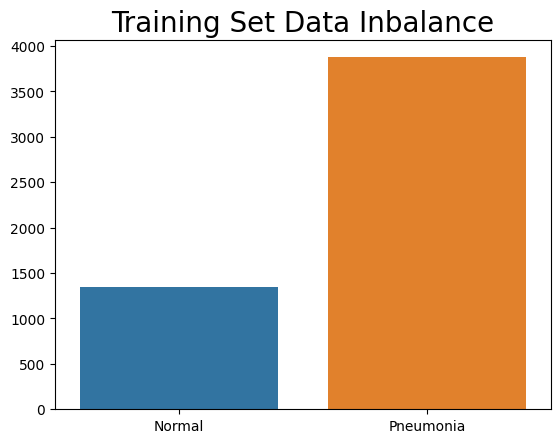

In [3]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

 We have imbalance in the training data therefore there is need for data augmentation

## Data Augmentation

In [4]:
transformer = {
    'dataset1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

In [5]:
dataset1 = ImageFolder(path+'/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder(path+'/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder(path+'/train', 
                      transform=transformer['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([dataset1, norm1, norm2])

len(dataset)

7750

There are 7750 images in the training set after augmentation

In [6]:
print(dataset1.classes)

['NORMAL', 'PNEUMONIA']


There are 2 major classes. Normal and Pneumonia set of images

## Data Visualization 

In [7]:
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

### Plotting the x-ray images

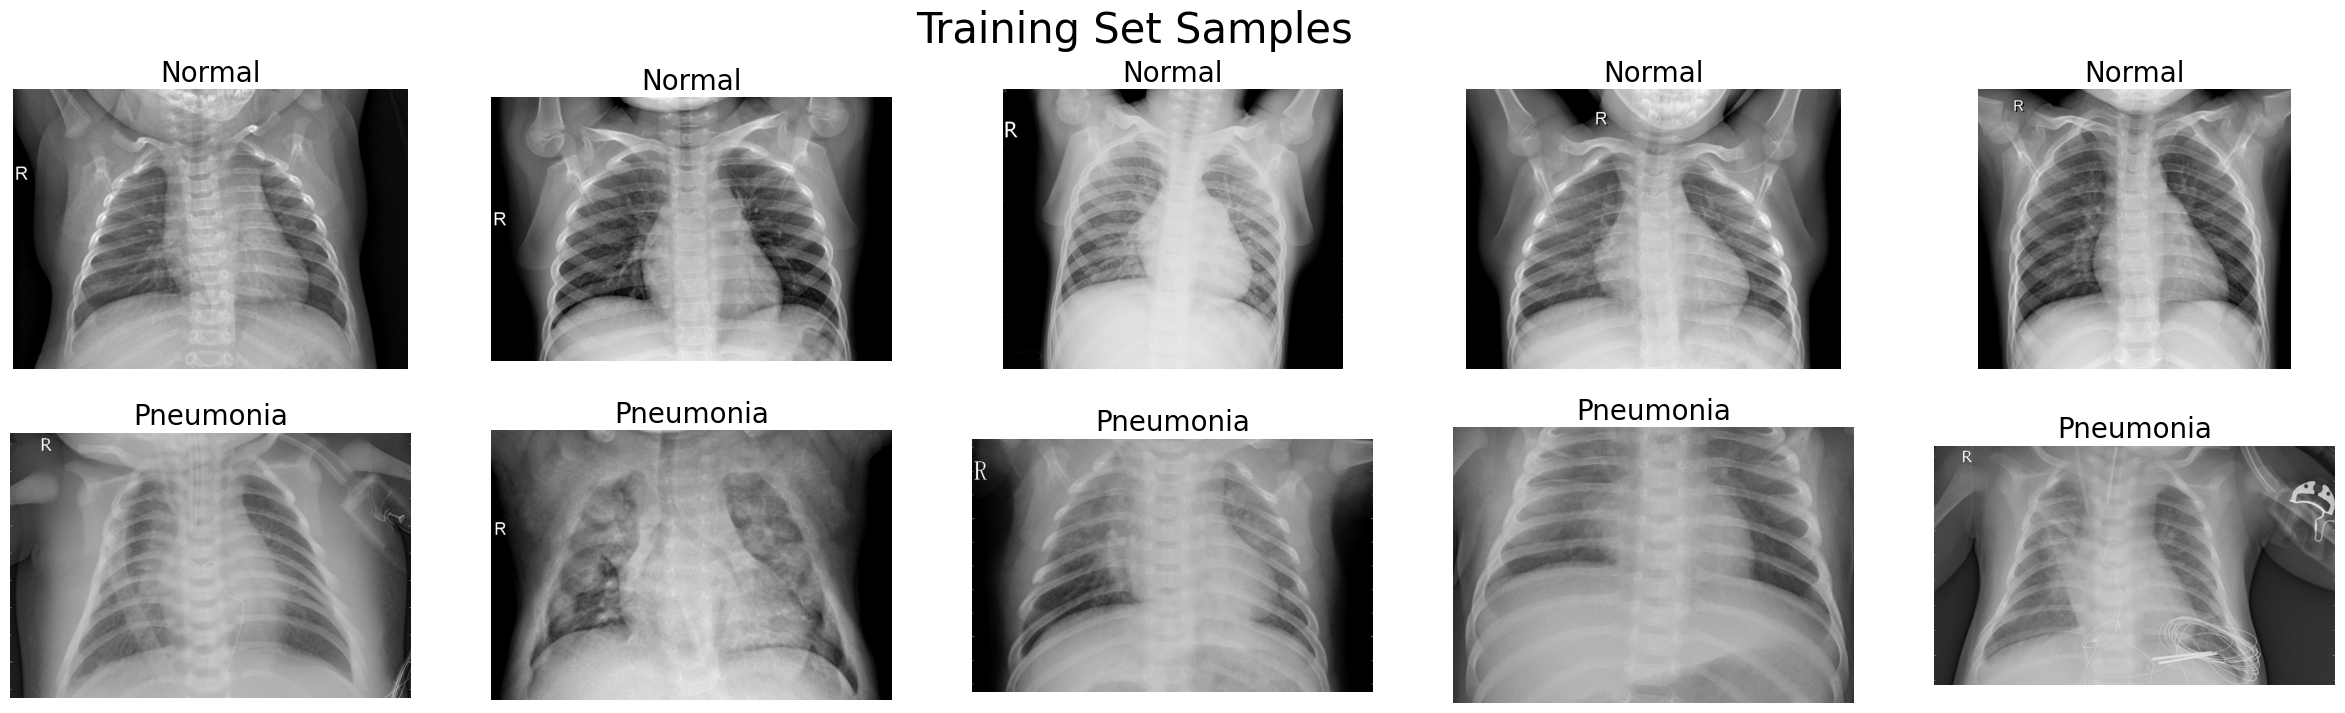

In [8]:
rand_samples = random.sample([os.path.join(path+'/train/NORMAL', filename) 
                              for filename in os.listdir(path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(path+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

We can observe the difference between the normal and pneumonia x-ray images in the dataset

## Data Preparation

In this part, we will split the 'train' folder into validation and training parts. It seems strange, because there is a separate folder with validation, but the fact is that there are only 16 images and this is clearly not enough to adequately evaluate the model, so you have to sacrifice part of the data for validation. We will split the data in a ratio of 3/10, of course, in favor of the training data.

In [9]:
random_seed = 2020
torch.manual_seed(random_seed);

In [10]:
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

We split the dataset in the ratio of 70:30 for training and testing the model. We have 5425 images for training and 2325 for testing

In [11]:
batch_size=50

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

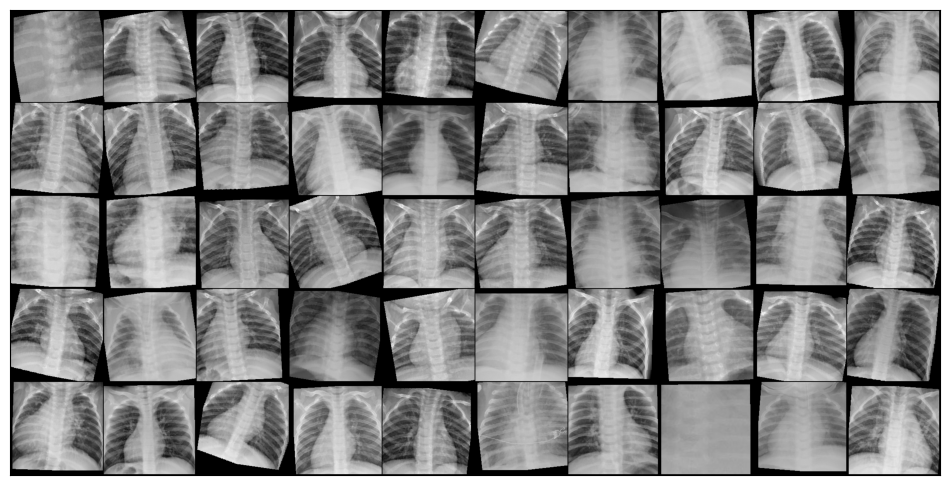

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

This is the visualization of training set of data that has both Normal and Pneumonia set of images

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

## Model Training

### Densenet161 model is used for Convolution Neural Network 

In [14]:
model = torchvision.models.densenet161(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 155MB/s]


The upper (first) layers of the network are frozen, the lower ones are retrained. The upper layers highlight low-level information, and they've learned to do this well in pre-training. The lower layers are separated from the information obtained from the upper layers, information specific to the task, so they need to be retrained.

How many layers to freeze depends on the difference between the datasets, the complexity of the task and the size of the dataset for additional training. DenseNet has only one fully connected layer, so we'll only train it, and freeze the rest of the network. We will also change the last layer, since it was originally trained in 1000 classes, and we have only 2

In [15]:
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 2)

In [16]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

#### Training function

In [17]:
def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0
    
      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
                 
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
     
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [19]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.29317712042188865, accuracy0.9024884792626728
val - loss:0.1684188713790268, accuracy0.9513978494623656
Time: 0.0m 32.09494876861572s
Epoch: 2/10
train - loss:0.1623569172442234, accuracy0.944516129032258
val - loss:0.13257773773324105, accuracy0.9578494623655914
Time: 1.0m 3.017416000366211s
Epoch: 3/10
train - loss:0.13531235849253043, accuracy0.9563133640552995
val - loss:0.11908081454294984, accuracy0.9561290322580646
Time: 1.0m 33.91155195236206s
Epoch: 4/10
train - loss:0.11711522778882409, accuracy0.959815668202765
val - loss:0.1106700092674263, accuracy0.9591397849462365
Time: 2.0m 4.63877272605896s
Epoch: 5/10
train - loss:0.10780013704560869, accuracy0.9647926267281106
val - loss:0.11039810884062962, accuracy0.9574193548387097
Time: 2.0m 35.5765483379364s
Epoch: 6/10
train - loss:0.1024960368734351, accuracy0.9666359447004609
val - loss:0.11077142444749673, accuracy0.9612903225806452
Time: 3.0m 6.375660419464111s
Epoch: 7/10
train - loss:0.103094504

It is good practice to retrain the rest of the network after we have trained the last layer. In most cases, this leads to an increase in performance, but in my practice there have been cases when, due to a small dataset, this led to a performance degradation, so my advice is to check two options. Learning rate can be reduced by 10 times

In [20]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model.to(device)
grad_clip = None
weight_decay = 1e-4
# weighted loss for data class imbalance
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.08233519267582673, accuracy0.9710599078341013
val - loss:0.07520529053985112, accuracy0.9754838709677419
Time: 1.0m 14.136074304580688s
Epoch: 2/10
train - loss:0.026750997783699874, accuracy0.991336405529954
val - loss:0.048753774434488306, accuracy0.984516129032258
Time: 2.0m 28.198442697525024s
Epoch: 3/10
train - loss:0.012053746718588481, accuracy0.9948387096774194
val - loss:0.05004225288529039, accuracy0.9858064516129033
Time: 3.0m 42.18978309631348s
Epoch: 4/10
train - loss:0.004067599527767971, accuracy0.9988940092165899
val - loss:0.0524637684724713, accuracy0.9866666666666667
Time: 4.0m 56.12141513824463s
Epoch: 5/10
train - loss:0.004698827032039794, accuracy0.9981566820276497
val - loss:0.0677679839533984, accuracy0.9789247311827957
Time: 6.0m 10.173975229263306s
Epoch: 6/10
train - loss:0.020824931005277433, accuracy0.9933640552995392
val - loss:0.06064705957248006, accuracy0.9802150537634409
Time: 7.0m 24.16472101211548s
Epoch: 7/10
train - los

## Plot Accuracy and Loss

Let's display our results to see how the idea worked with additional training of the entire network, whether we selected the learning rate correctly and whether the network is being retrained. As you can see from the graph, the idea worked and we really increased productivity. (attention to the network after the 10th epoch)

In [21]:
for key in accuracies.keys():
    accuracies[key] = np.array([tensor.cpu().numpy() for tensor in accuracies[key]])

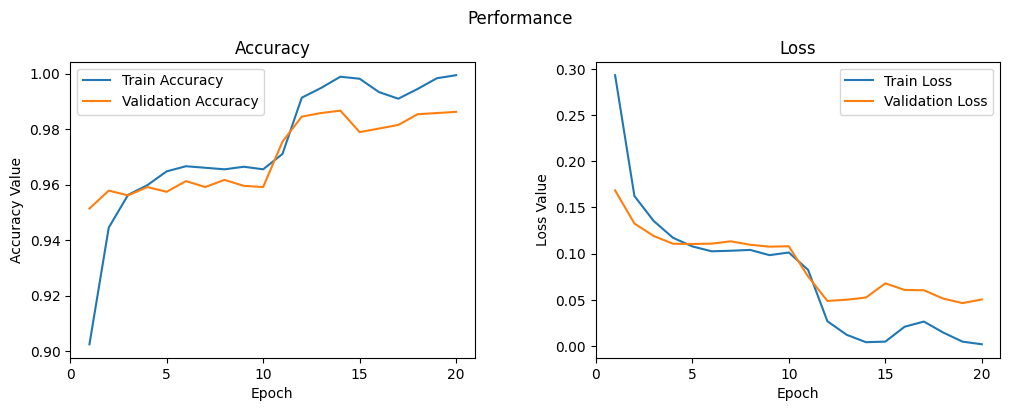

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs*2+1))
ax1.plot(epoch_list, accuracies['train'], label='Train Accuracy')
ax1.plot(epoch_list, accuracies['val'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs*2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, losses['train'], label='Train Loss')
ax2.plot(epoch_list, losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs*2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Test
Now look at the X-ray-trained network on data it has never seen.

The test data also shows an imbalance

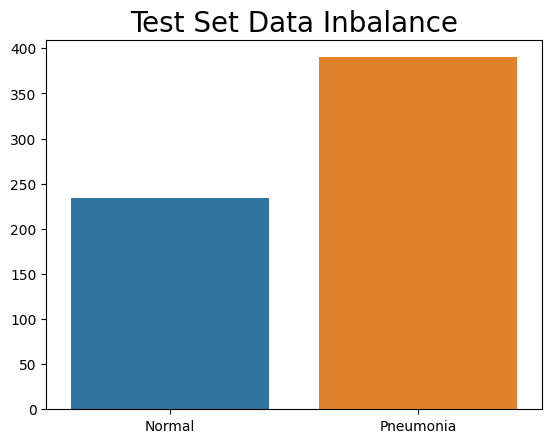

In [23]:
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/test/NORMAL', filename) 
                     for filename in os.listdir(path+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

The following three functions are needed to calculate metrics

In [24]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [25]:
 def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

In [26]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [27]:
testset = ImageFolder(path+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor(),
                                                ]))

Evaluate test set

In [28]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.5325, test_acc: 0.9111


## Calculation of some more metrics and visualization of predictions

<Figure size 640x480 with 0 Axes>

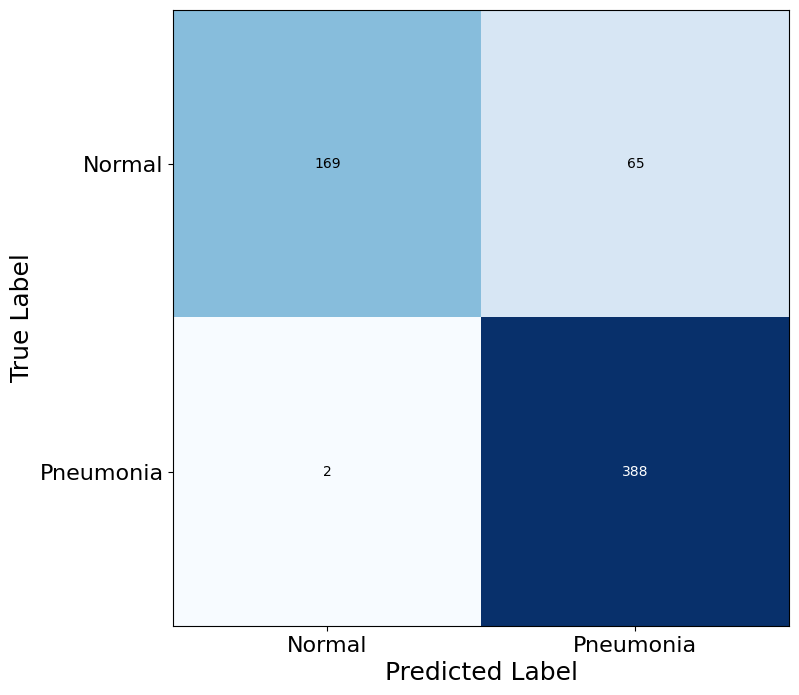

In [29]:
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [30]:
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.89
Recall of the model is 0.99
Precision of the model is 0.86
F1 Score of the model is 0.92


Look at X-rays and predictions

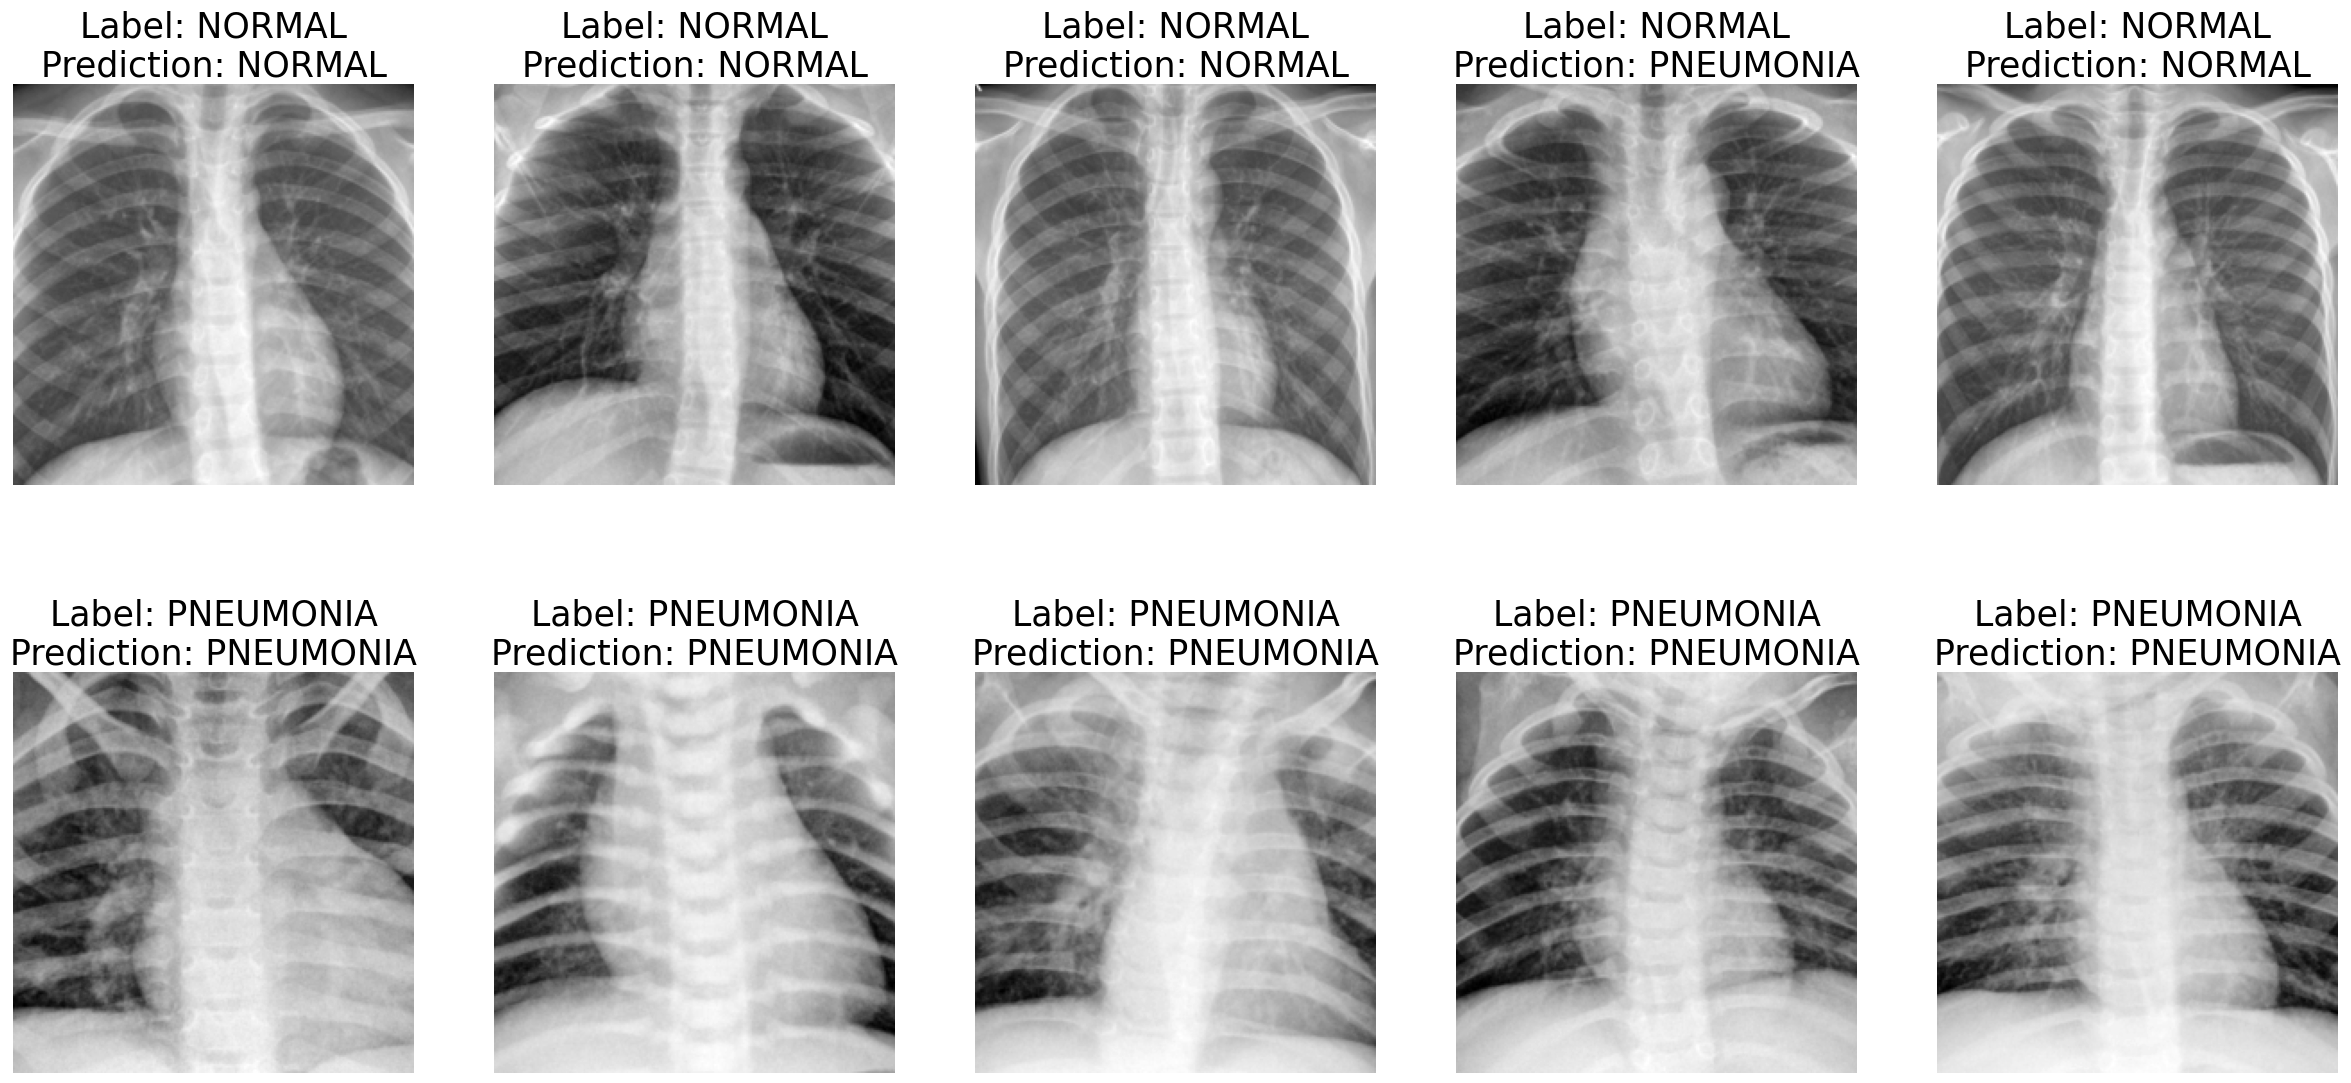

In [31]:
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = testset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(testset.classes[label], 
                                    testset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

We can also see how strongly the neural network is confident in certain decisions.

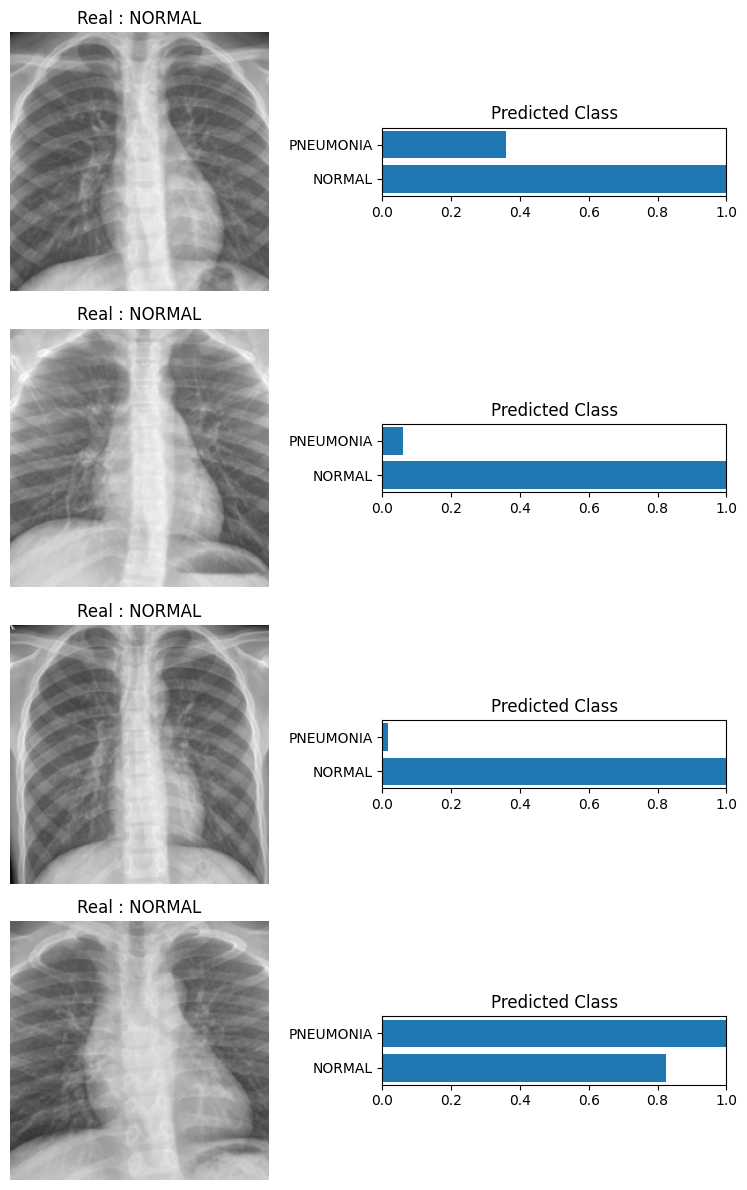

In [32]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

for row in range(4):
    img,label = testset[row]
    pred = torch.exp(model(img.to(device).unsqueeze(0)))
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)
    pred = pred.cpu().data.numpy().squeeze()
    ax[row][0].imshow(img.permute(1, 2, 0))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, pred)
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_yticklabels(classes)
    ax[row][1].set_title('Predicted Class')
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()